### Connecting Pytorch Metal

In [1]:
import torch
if torch.backends.mps.is_available():
    mps_device = torch.device("mps")
    x = torch.ones(1, device=mps_device)
    print(x)
else:
    print("MPS device not found.")

MPS device not found.


### Importing Libraries

In [7]:
import torch
import os
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import DataLoader, Dataset
import torch.optim as optim
import pandas as pd
from sklearn.model_selection import train_test_split
import numpy as np
import matplotlib.pyplot as plt

### Loading the data

In [8]:
data = pd.read_csv('data/movies_grouplens/ratings.dat',
                   delimiter='::', header=None, engine='python', encoding='latin1')
data.columns = ['user', 'event', 'rating', 'timestamp']
data.head()

,user,event,rating,timestamp
0,1,1193,5,978300760
1,1,661,3,978302109
2,1,914,3,978301968
3,1,3408,4,978300275
4,1,2355,5,978824291


### Pre-processing the data

In [9]:
users = data['user'].unique()
events = data['event'].unique()

events[:10], users[:10]

(array([1193,  661,  914, 3408, 2355, 1197, 1287, 2804,  594,  919]),
 array([ 1,  2,  3,  4,  5,  6,  7,  8,  9, 10]))

In [10]:
user_to_idx = {user: idx for idx, user in enumerate(users)}
event_to_idx = {event: idx for idx, event in enumerate(events)}
idx_to_user = {idx: user for user,
               idx in user_to_idx.items()}  # For reverse lookup
idx_to_event = {idx: event for event,
                idx in event_to_idx.items()}  # For reverse lookup

for key, value in user_to_idx.items():
    if value == 0:
        print(f'User: {key}, assigned index: {value}')

for key, value in event_to_idx.items():
    if value == 0:
        print(f'Event: {key}, assigned index: {value}')

User: 1, assigned index: 0
Event: 1193, assigned index: 0


In [11]:
data['user_idx'] = data['user'].map(user_to_idx)
data['event_idx'] = data['event'].map(event_to_idx)

data.head()

,user,event,rating,timestamp,user_idx,event_idx
0,1,1193,5,978300760,0,0
1,1,661,3,978302109,0,1
2,1,914,3,978301968,0,2
3,1,3408,4,978300275,0,3
4,1,2355,5,978824291,0,4


In [12]:
train_data, test_data = train_test_split(
    data, test_size=0.2, random_state=21, shuffle=True)
train_data, val_data = train_test_split(
    train_data, test_size=0.25, random_state=21, shuffle=True)
len(train_data), len(val_data), len(test_data)

(600125, 200042, 200042)

In [ ]:
train_dataloader = DataLoader(
    train_data[['user_idx', 'event_idx', 'rating']].values, batch_size=64, shuffle=False)
val_dataloader = DataLoader(
    val_data[['user_idx', 'event_idx', 'rating']].values, batch_size=64, shuffle=False)
test_dataloader = DataLoader(
    test_data[['user_idx', 'event_idx', 'rating']].values, batch_size=1, shuffle=False)

In [ ]:
for batch in train_dataloader:
    print('Example batch: ', batch[:10])
    print()
    print('Len of a batch: ', len(batch))
    break

Example batch:  tensor([[ 213, 1075,    4],
        [5619,  304,    2],
        [2536,  766,    3],
        [1469, 1458,    2],
        [1014, 2039,    4],
        [3086, 1855,    3],
        [5979,  121,    4],
        [5831,  345,    2],
        [ 779,  424,    3],
        [ 168,  381,    4]])

Len of a batch:  64


### CNN Feature Extractor

In [ ]:
class CNN_FeatureExtractor(nn.Module):
    def __init__(self, input_channels, embedding_dim, output_dim):
        super(CNN_FeatureExtractor, self).__init__()
        self.conv1 = nn.Conv1d(input_channels, 32, kernel_size=3, padding=1)
        self.conv2 = nn.Conv1d(32, 64, kernel_size=3, padding=1)
        self.pool = nn.AdaptiveAvgPool1d(1)
        self.fc = nn.Linear(64, output_dim)

    def forward(self, x):
        # print(f"CNN input shape: {x.shape}")
        x = F.relu(self.conv1(x))
        # print(f"After conv1: {x.shape}")
        # x = self.pool(x)
        # print(f"After pool1: {x.shape}")
        x = F.relu(self.conv2(x))
        # print(f"After conv2: {x.shape}")
        x = self.pool(x)
        # print(f"After pool2: {x.shape}")
        x = x.view(x.size(0), -1)
        # print(f"After flatten: {x.shape}")
        x = self.fc(x)
        # print(f"CNN output shape: {x.shape}")
        return x

### NCF with CNN

In [ ]:
class NCF_with_CNN(nn.Module):
    def __init__(self, num_users, num_items, embedding_dim=96, hidden_dim=64, cnn_output_dim=32, dropout_rate=0.5):
        super(NCF_with_CNN, self).__init__()

        self.user_embedding = nn.Embedding(num_users, embedding_dim)
        self.item_embedding = nn.Embedding(num_items, embedding_dim)

        self.user_cnn = CNN_FeatureExtractor(1, embedding_dim, cnn_output_dim)
        self.item_cnn = CNN_FeatureExtractor(1, embedding_dim, cnn_output_dim)

        self.fc1 = nn.Linear(cnn_output_dim * 2, hidden_dim)
        self.fc2 = nn.Linear(hidden_dim, 1)
        self.dropout = nn.Dropout(dropout_rate)

    def forward(self, user, item):
        user_emb = self.user_embedding(user)
        item_emb = self.item_embedding(item)

        user_features = self.user_cnn(user_emb.unsqueeze(1))
        item_features = self.item_cnn(item_emb.unsqueeze(1))

        x = torch.cat([user_features, item_features], dim=1)
        x = F.relu(self.fc1(x))
        x = self.dropout(x)
        x = self.fc2(x)
        return x

In [ ]:
class EarlyStopper:
    def __init__(self, patience=1, min_delta=0):
        self.patience = patience
        self.min_delta = min_delta
        self.counter = 0
        self.min_validation_loss = float('inf')

    def early_stop(self, validation_loss):
        if validation_loss < self.min_validation_loss:
            self.min_validation_loss = validation_loss
            self.counter = 0
        elif validation_loss > (self.min_validation_loss + self.min_delta):
            self.counter += 1
            if self.counter >= self.patience:
                return True
        return False

In [ ]:
from torch.optim.lr_scheduler import ReduceLROnPlateau
device = torch.device('mps' if torch.backends.mps.is_available() else 'cpu')
device = torch.device('cuda') if torch.cuda.is_available() else device
num_users = len(users)
num_items = len(events)
embedding_dim = 96
cnn_output_dim = 32
hidden_dim = 64
model = NCF_with_CNN(num_users, num_items,
                     cnn_output_dim=cnn_output_dim).to(device)
num_epochs = 10
lr = 1e-3
# optimizer = optim.Adam(model.parameters(), lr=lr)
optimizer = optim.Adam(model.parameters(), lr=lr, weight_decay=1e-4)

scheduler = ReduceLROnPlateau(
    optimizer, mode='min', factor=0.1, patience=3, verbose=True)

criterion = nn.MSELoss()
early_stopper = EarlyStopper(patience=3, min_delta=0.0001)

/home/shounakpaul/.conda/envs/torch/lib/python3.9/site-packages/torch/optim/lr_scheduler.py:62: UserWarning: The verbose parameter is deprecated. Please use get_last_lr() to access the learning rate.
  warnings.warn(


In [ ]:
def calculate_metrics(predictions, targets):
    mae = nn.L1Loss()(predictions, targets).item()
    mse = nn.MSELoss()(predictions, targets).item()
    rmse = np.sqrt(mse)
    return mae, rmse

### Training

In [ ]:
def train(model, train_dataloader, val_dataloader, optimizer, scheduler, criterion, device, num_epochs=30):
    model.train()
    train_losses, val_losses = [], []
    train_maes, val_maes = [], []
    train_rmses, val_rmses = [], []

    for epoch in range(num_epochs):
        total_loss, total_mae, total_rmse = 0, 0, 0
        model.train()

        for batch in train_dataloader:
            user, event, target = batch[:, 0].to(device), batch[:, 1].to(
                device), batch[:, 2].float().to(device)
            optimizer.zero_grad()
            output = model(user, event).squeeze()
            loss = criterion(output, target)
            loss.backward()
            optimizer.step()

            total_loss += loss.item()
            mae, rmse = calculate_metrics(output, target)
            total_mae += mae
            total_rmse += rmse

        avg_train_loss = total_loss / len(train_dataloader)
        avg_train_mae = total_mae / len(train_dataloader)
        avg_train_rmse = total_rmse / len(train_dataloader)
        train_losses.append(avg_train_loss)
        train_maes.append(avg_train_mae)
        train_rmses.append(avg_train_rmse)

        # Validation phase
        model.eval()
        val_loss, val_mae, val_rmse = 0, 0, 0
        with torch.no_grad():
            for batch in val_dataloader:
                user, event, target = batch[:, 0].to(device), batch[:, 1].to(
                    device), batch[:, 2].float().to(device)
                output = model(user, event).squeeze()
                val_loss += criterion(output, target).item()
                mae, rmse = calculate_metrics(output, target)
                val_mae += mae
                val_rmse += rmse

        avg_val_loss = val_loss / len(val_dataloader)
        avg_val_mae = val_mae / len(val_dataloader)
        avg_val_rmse = val_rmse / len(val_dataloader)
        val_losses.append(avg_val_loss)
        val_maes.append(avg_val_mae)
        val_rmses.append(avg_val_rmse)

        # Learning rate scheduling
        scheduler.step(avg_val_loss)
        if early_stopper.early_stop(avg_val_rmse):
            return train_losses, val_losses, train_maes, val_maes, train_rmses, val_rmses

        print(f'Epoch: {epoch+1}/{num_epochs}, '
              f'Train Loss: {avg_train_loss:.4f}, Train MAE: {avg_train_mae:.4f}, Train RMSE: {avg_train_rmse:.4f}, '
              f'Val Loss: {avg_val_loss:.4f}, Val MAE: {avg_val_mae:.4f}, Val RMSE: {avg_val_rmse:.4f}')

    return train_losses, val_losses, train_maes, val_maes, train_rmses, val_rmses

In [ ]:
train_losses, val_losses, train_maes, val_maes, train_rmses, val_rmses = train(
    model, train_dataloader, val_dataloader, optimizer, scheduler, criterion, device, num_epochs=30
)

Epoch: 1/30, Train Loss: 1.1810, Train MAE: 0.8645, Train RMSE: 1.0706, Val Loss: 0.8906, Val MAE: 0.7586, Val RMSE: 0.9401


KeyboardInterrupt: 

### Plotting

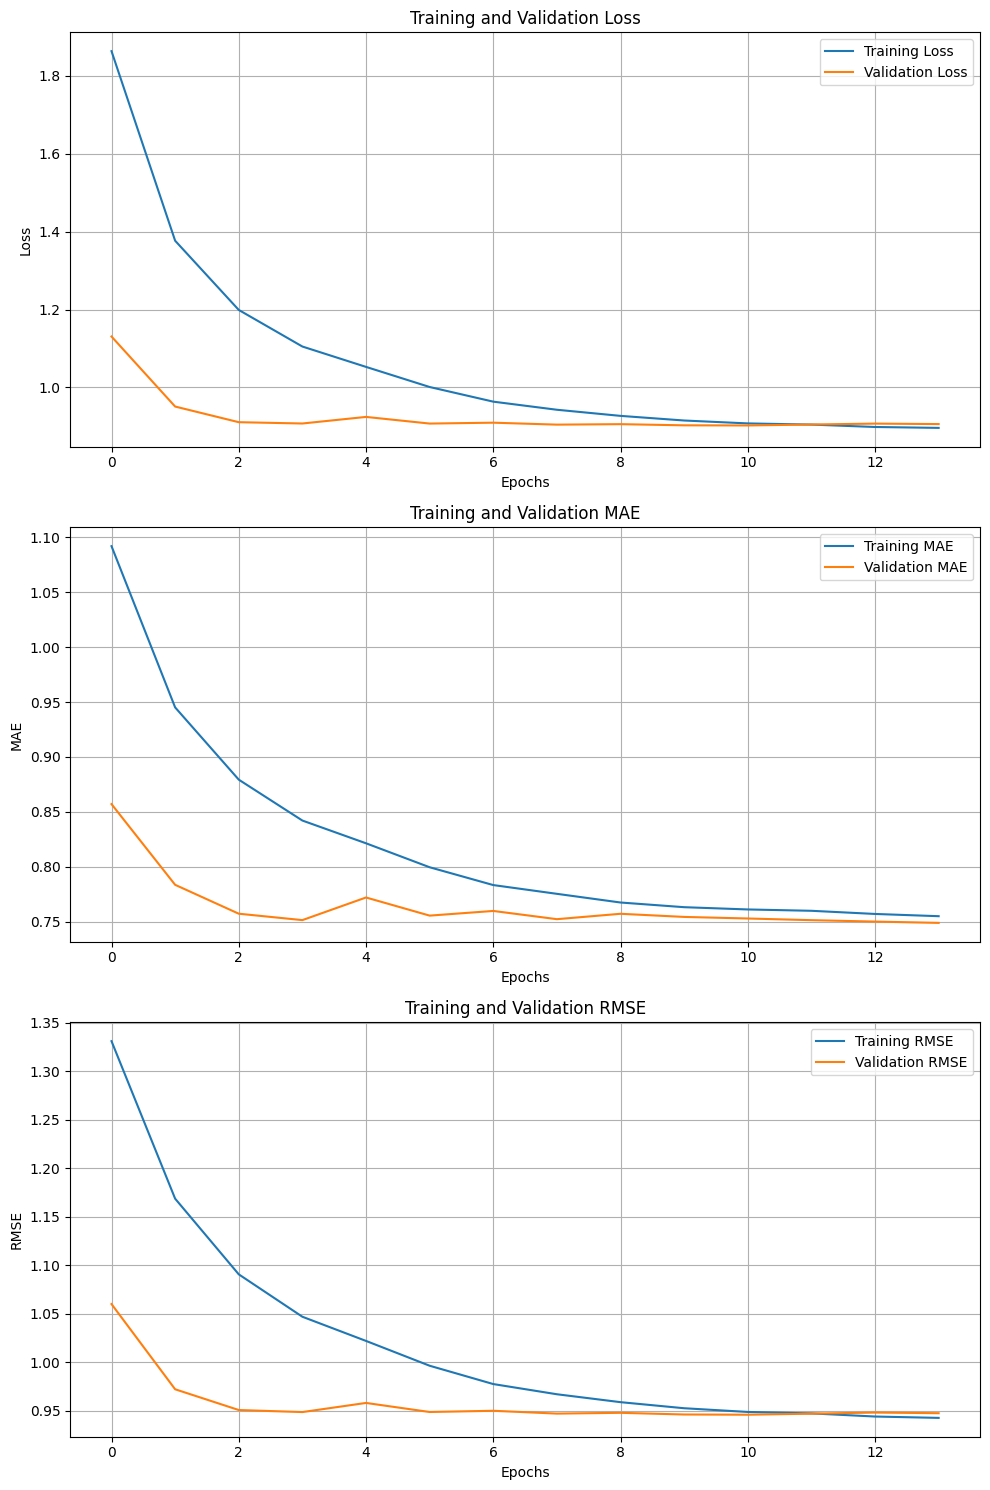

In [ ]:
# Plotting
fig, (ax1, ax2, ax3) = plt.subplots(3, 1, figsize=(10, 15))

# Loss plot
ax1.plot(train_losses, label='Training Loss')
ax1.plot(val_losses, label='Validation Loss')
ax1.set_xlabel('Epochs')
ax1.set_ylabel('Loss')
ax1.set_title('Training and Validation Loss')
ax1.legend()
ax1.grid(True)

# MAE plot
ax2.plot(train_maes, label='Training MAE')
ax2.plot(val_maes, label='Validation MAE')
ax2.set_xlabel('Epochs')
ax2.set_ylabel('MAE')
ax2.set_title('Training and Validation MAE')
ax2.legend()
ax2.grid(True)

# RMSE plot
ax3.plot(train_rmses, label='Training RMSE')
ax3.plot(val_rmses, label='Validation RMSE')
ax3.set_xlabel('Epochs')
ax3.set_ylabel('RMSE')
ax3.set_title('Training and Validation RMSE')
ax3.legend()
ax3.grid(True)

plt.tight_layout()
plt.show()

In [ ]:
def evaluate(model, dataloader, device):
    model.eval()
    total_loss = 0
    with torch.no_grad():
        for batch in dataloader:
            user, event, target = batch[:, 0].to(device), batch[:, 1].to(
                device), batch[:, 2].float().to(device)
            output = model(user, event).squeeze()
            loss = criterion(output, target)
            total_loss += loss.item()
    return total_loss / len(dataloader)

In [ ]:
evaluate(model, test_dataloader, device)

/home/tanmaypatil/Documents/DS/hybrid-recommendation-system/.venv/lib64/python3.12/site-packages/torch/nn/modules/loss.py:608: UserWarning: Using a target size (torch.Size([1])) that is different to the input size (torch.Size([])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


0.8825813058068427

## Saving the Model

In [ ]:
model_scripted = torch.jit.script(model)
model_scripted.save(os.path.join('models', 'NCF_CNN.pt'))

## Load Model

In [19]:
device = torch.device('mps' if torch.backends.mps.is_available() else 'cpu')
device = torch.device('cuda') if torch.cuda.is_available() else device
print(device)

cuda


In [4]:
model = torch.jit.load('models/NCF_CNN.pt').to(device)

In [5]:
def get_recommendations(user_id, data, model, idx_to_event, idx_to_user, user_to_idx, k=10):
    model.eval()
    not_watched = []
    list_ratings = []
    user_idx = user_to_idx[user_id]
    events = [0, 4, 22, 38, 41, 50]
    event_idx = np.arange(
        np.min(data['event_idx']), np.max(data['event_idx'])+1, 1)
    for event in event_idx:
        if (not len(data[(data['user_idx'] == user_idx) & (data['event_idx'] == event)]['event_idx'].to_list())) or event in events:
            not_watched.append(event)
        else:
            print(f'Already Wacthed {event}')
    for movie in not_watched:
        rating = model(torch.tensor([user_idx]).to(device),
                       torch.tensor([movie]).to(device))

        list_ratings.append([user_id, idx_to_event[int(movie)], rating.item()])
    recommendations = sorted(
        list_ratings, key=lambda x: x[2], reverse=True)
    return recommendations

In [13]:
get_recommendations(582, data, model, idx_to_event, idx_to_user, user_to_idx)

Already Wacthed 52
Already Wacthed 64
Already Wacthed 68
Already Wacthed 94
Already Wacthed 96
Already Wacthed 104
Already Wacthed 218
Already Wacthed 237
Already Wacthed 243
Already Wacthed 263
Already Wacthed 268
Already Wacthed 273
Already Wacthed 277
Already Wacthed 287
Already Wacthed 307
Already Wacthed 308
Already Wacthed 315
Already Wacthed 317
Already Wacthed 327
Already Wacthed 332
Already Wacthed 340
Already Wacthed 352
Already Wacthed 359
Already Wacthed 363
Already Wacthed 383
Already Wacthed 387
Already Wacthed 406
Already Wacthed 441
Already Wacthed 445
Already Wacthed 452
Already Wacthed 508
Already Wacthed 532
Already Wacthed 541
Already Wacthed 628
Already Wacthed 651
Already Wacthed 697
Already Wacthed 732
Already Wacthed 733
Already Wacthed 788
Already Wacthed 790
Already Wacthed 860
Already Wacthed 866
Already Wacthed 869
Already Wacthed 872
Already Wacthed 873
Already Wacthed 876
Already Wacthed 877
Already Wacthed 881
Already Wacthed 889
Already Wacthed 897
Alrea

[[582, np.int64(50), 4.737315654754639],
 [582, np.int64(908), 4.7281622886657715],
 [582, np.int64(527), 4.719417572021484],
 [582, np.int64(318), 4.693853378295898],
 [582, np.int64(1198), 4.669875621795654],
 [582, np.int64(1207), 4.664440155029297],
 [582, np.int64(858), 4.652575492858887],
 [582, np.int64(593), 4.648096561431885],
 [582, np.int64(922), 4.644453048706055],
 [582, np.int64(1178), 4.6394500732421875],
 [582, np.int64(260), 4.639429092407227],
 [582, np.int64(2762), 4.631246089935303],
 [582, np.int64(745), 4.630960941314697],
 [582, np.int64(1250), 4.6299662590026855],
 [582, np.int64(2019), 4.624085426330566],
 [582, np.int64(2571), 4.6036906242370605],
 [582, np.int64(904), 4.597725868225098],
 [582, np.int64(1262), 4.5884175300598145],
 [582, np.int64(923), 4.587425708770752],
 [582, np.int64(541), 4.581330299377441],
 [582, np.int64(1193), 4.575336933135986],
 [582, np.int64(296), 4.573071479797363],
 [582, np.int64(1223), 4.5683746337890625],
 [582, np.int64(122

In [14]:
import torch


def precision_at_k(model, data, k=10, device='cpu', rating_threshold=3.0):
    model.eval()

    unique_users = data['user_idx'].unique()
    precisions = []

    for user_id in unique_users:
        # Get items the user rated as relevant (above the threshold)
        relevant_data = data[(data['user_idx'] == user_id) & (
            data['rating'] >= rating_threshold)]
        relevant_events = set(relevant_data['event_idx'])

        # Get the user's interacted items (both relevant and non-relevant)
        interacted_events = set(data[data['user_idx'] == user_id]['event_idx'])

        # We skip users with no relevant items
        if not relevant_events:
            continue

        # Candidate events include all events except the ones user rated below the threshold
        candidate_events = list(
            set(data['event_idx'].unique()) - (interacted_events - relevant_events))

        user_tensor = torch.tensor(
            [user_id] * len(candidate_events)).to(device)
        event_tensor = torch.tensor(candidate_events).to(device)

        with torch.no_grad():
            predictions = model(user_tensor, event_tensor).squeeze()

        # Get top K recommendations
        top_k_indices = torch.topk(predictions, k).indices
        top_k_events = [candidate_events[idx] for idx in top_k_indices]

        # Calculate Precision@K
        num_relevant_in_top_k = sum(
            [1 for event in top_k_events if event in relevant_events])
        precision = num_relevant_in_top_k / k
        precisions.append(precision)

    # Average Precision@K across all users
    mean_precision_at_k = sum(precisions) / \
        len(precisions) if precisions else 0
    return mean_precision_at_k

In [15]:
import numpy as np


def ndcg_at_k(model, data, k=10, device='cpu', rating_threshold=4.0):
    model.eval()

    unique_users = data['user_idx'].unique()
    ndcgs = []

    for user_id in unique_users:
        # Get items the user rated as relevant (above the threshold)
        relevant_data = data[(data['user_idx'] == user_id) & (
            data['rating'] >= rating_threshold)]
        relevant_events = set(relevant_data['event_idx'])

        # Get the user's interacted items (both relevant and non-relevant)
        interacted_events = set(data[data['user_idx'] == user_id]['event_idx'])

        # We skip users with no relevant items
        if not relevant_events:
            continue

        # Candidate events include all events except those the user rated below the threshold
        candidate_events = list(
            set(data['event_idx'].unique()) - (interacted_events - relevant_events))

        user_tensor = torch.tensor(
            [user_id] * len(candidate_events)).to(device)
        event_tensor = torch.tensor(candidate_events).to(device)

        with torch.no_grad():
            predictions = model(user_tensor, event_tensor).squeeze()

        # Get top K recommendations
        top_k_indices = torch.topk(predictions, k).indices
        top_k_events = [candidate_events[idx] for idx in top_k_indices]

        # Calculate DCG
        dcg = 0
        for i, event in enumerate(top_k_events):
            if event in relevant_events:
                # Adding 1 to i to convert 0-indexed to 1-indexed
                dcg += 1 / np.log2(i + 2)

        # Calculate IDCG (Ideal DCG)
        ideal_relevances = [1 / np.log2(i + 2)
                            for i in range(min(len(relevant_events), k))]
        idcg = sum(ideal_relevances)

        # NDCG Calculation
        ndcg = dcg / idcg if idcg > 0 else 0
        ndcgs.append(ndcg)

    # Average NDCG across all users
    mean_ndcg_at_k = sum(ndcgs) / len(ndcgs) if ndcgs else 0
    return mean_ndcg_at_k

In [16]:
from sklearn.metrics import r2_score


def r2_score_model(model, data, device='cpu', rating_threshold=4.0):
    model.eval()

    # Predictions and true values
    with torch.no_grad():
        y_true = []
        y_pred = []

        for user_id in data['user_idx'].unique():
            user_data = data[data['user_idx'] == user_id]

            # Get items the user rated as relevant (above the threshold)
            relevant_data = user_data[user_data['rating'] >= rating_threshold]

            if relevant_data.empty:
                continue

            # Get all items to predict ratings for
            user_tensor = torch.tensor(
                user_data['user_idx'].to_list()).to(device)
            event_tensor = torch.tensor(
                user_data['event_idx'].to_list()).to(device)

            with torch.no_grad():
                predictions = model(user_tensor, event_tensor).squeeze()

            y_true.extend(user_data['rating'].tolist())
            y_pred.extend(predictions.cpu().numpy().tolist())

        return r2_score(y_true, y_pred)

In [17]:
def recall_at_k(model, data, k=10, device='cpu', rating_threshold=4.0):
    model.eval()

    unique_users = data['user_idx'].unique()
    recalls = []

    for user_id in unique_users:
        # Get items the user rated as relevant (above the threshold)
        relevant_data = data[(data['user_idx'] == user_id) & (
            data['rating'] >= rating_threshold)]
        relevant_events = set(relevant_data['event_idx'])

        # Get the user's interacted items (both relevant and non-relevant)
        interacted_events = set(data[data['user_idx'] == user_id]['event_idx'])

        # We skip users with no relevant items
        if not relevant_events:
            continue

        # Candidate events include all events except those rated below the threshold
        candidate_events = list(
            set(data['event_idx'].unique()) - (interacted_events - relevant_events))

        user_tensor = torch.tensor(
            [user_id] * len(candidate_events)).to(device)
        event_tensor = torch.tensor(candidate_events).to(device)

        with torch.no_grad():
            predictions = model(user_tensor, event_tensor).squeeze()

        # Get top K recommendations
        top_k_indices = torch.topk(predictions, k).indices
        top_k_events = [candidate_events[idx] for idx in top_k_indices]

        # Calculate Recall@K
        num_relevant_in_top_k = sum(
            [1 for event in top_k_events if event in relevant_events])
        recall = num_relevant_in_top_k / \
            len(relevant_events) if relevant_events else 0
        recalls.append(recall)

    # Average Recall@K across all users
    mean_recall_at_k = sum(recalls) / len(recalls) if recalls else 0
    return mean_recall_at_k

In [18]:
# Assuming the model and data are already defined, as in your code
recall_k = precision_at_k(model, data, k=5, device=device)
print(f"Precision@10: {recall_k:.4f}")

Precision@10: 0.3314


In [20]:
mean_ndcg_at_k = ndcg_at_k(
    model, data, k=10, device=device, rating_threshold=3.0)
print(f"NDCG@10: {mean_ndcg_at_k:.4f}")

NDCG@10: 0.2811


In [21]:
mean_r2 = r2_score_model(model, data, device=device)
print("R² Score:", mean_r2)

R² Score: 0.3027493356095846


In [22]:
recall_k = precision_at_k(model, data, k=5, device=device)
print(f"Recall@10: {recall_k:.4f}")

Recall@10: 0.3314


In [23]:
k_values = [1, 5, 10, 15, 20, 25, 40, 50]
precision_values = []
recall_values = []
ndcg_values = []

for k in k_values:
    precision_k = precision_at_k(model, data, k, device=device)
    recall_k = recall_at_k(model, data, k, device=device)
    ndcg_k = ndcg_at_k(model, data, k, device=device)
    
    precision_values.append(precision_k)
    recall_values.append(recall_k)
    ndcg_values.append(ndcg_k)
    
    print(f"Precision@{k}: {precision_k:.4f}")
    print(f"Recall@{k}: {recall_k:.4f}")
    print(f"NDCG@{k}: {ndcg_k:.4f}")

Precision@1: 0.2914
Recall@1: 0.0034
NDCG@1: 0.2769
Precision@5: 0.3314
Recall@5: 0.0217
NDCG@5: 0.3001
Precision@10: 0.2720
Recall@10: 0.0359
NDCG@10: 0.2685
Precision@15: 0.2642
Recall@15: 0.0524
NDCG@15: 0.2616
Precision@20: 0.2577
Recall@20: 0.0667
NDCG@20: 0.2576
Precision@25: 0.2654
Recall@25: 0.0862
NDCG@25: 0.2597
Precision@40: 0.2339
Recall@40: 0.1165
NDCG@40: 0.2440
Precision@50: 0.2139
Recall@50: 0.1288
NDCG@50: 0.2338


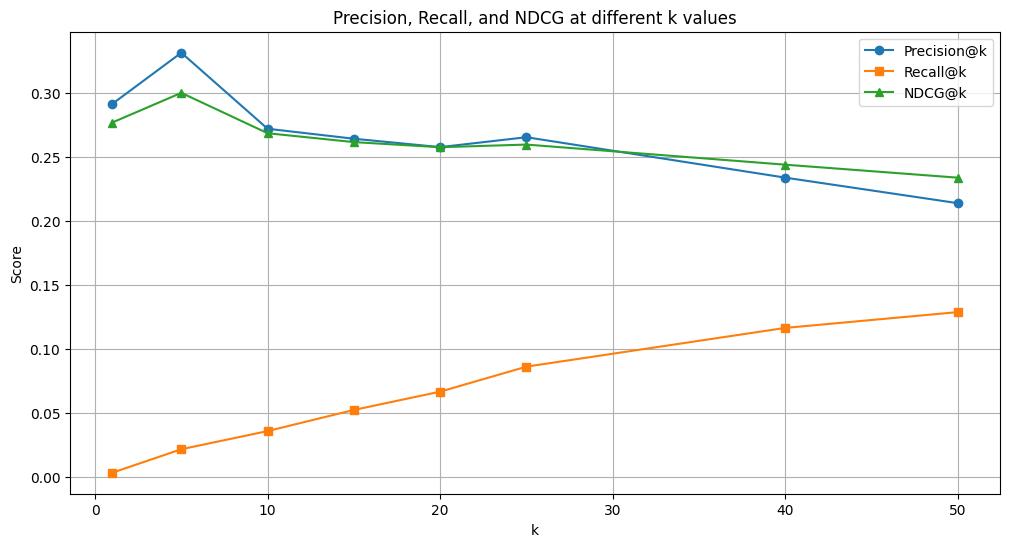

In [24]:
plt.figure(figsize=(12, 6))
plt.plot(k_values, precision_values, label="Precision@k", marker="o")
plt.plot(k_values, recall_values, label="Recall@k", marker="s")
plt.plot(k_values, ndcg_values, label="NDCG@k", marker="^")
plt.xlabel("k")
plt.ylabel("Score")
plt.title("Precision, Recall, and NDCG at different k values")
plt.legend()
plt.grid()
plt.show()

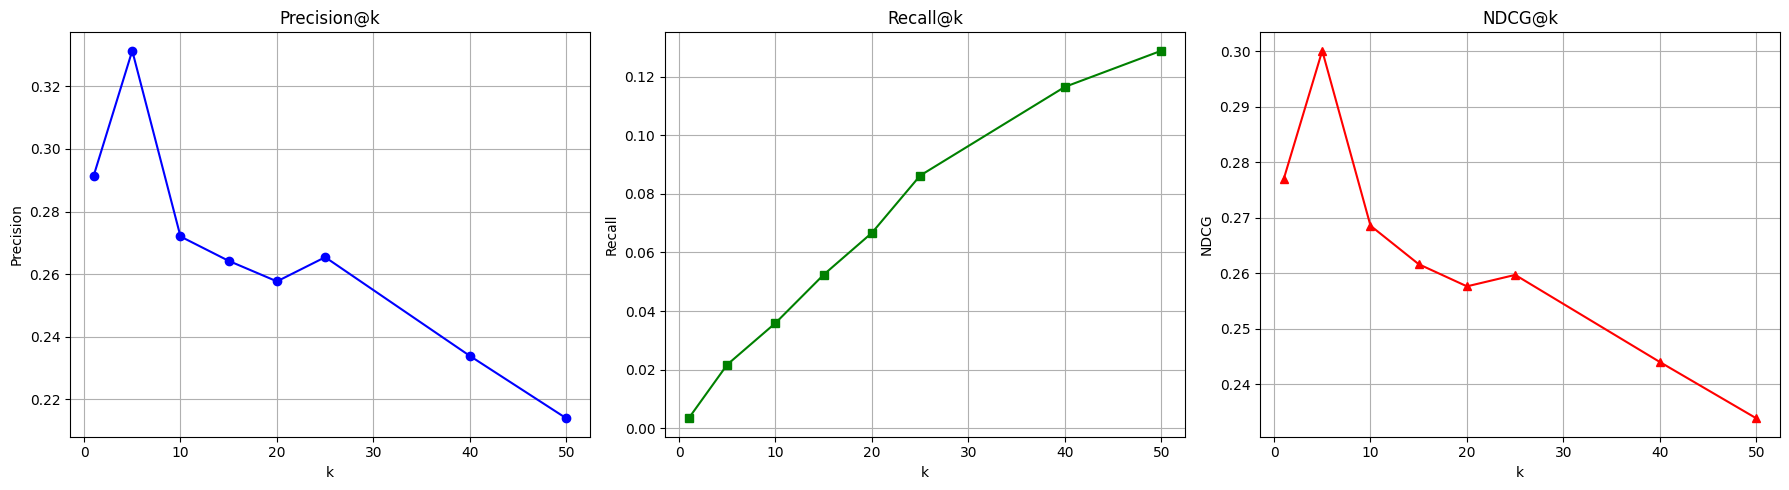

In [ ]:
fig, axs = plt.subplots(1, 3, figsize=(18, 5))

axs[0].plot(k_values, precision_values, label="Precision@k", marker="o", color='b')
axs[0].set_xlabel("k")
axs[0].set_ylabel("Precision")
axs[0].set_title("Precision@k")
axs[0].grid()

axs[1].plot(k_values, recall_values, label="Recall@k", marker="s", color='g')
axs[1].set_xlabel("k")
axs[1].set_ylabel("Recall")
axs[1].set_title("Recall@k")
axs[1].grid()

axs[2].plot(k_values, ndcg_values, label="NDCG@k", marker="^", color='r')
axs[2].set_xlabel("k")
axs[2].set_ylabel("NDCG")
axs[2].set_title("NDCG@k")
axs[2].grid()

plt.tight_layout()
plt.show()


In [27]:
import csv

with open("metrics_results.csv", mode="w", newline="") as file:
    writer = csv.writer(file)
    writer.writerow(["k", "Precision", "Recall", "NDCG"])  # Header row
    for i, k in enumerate(k_values):
        writer.writerow([k, precision_values[i], recall_values[i], ndcg_values[i]])

print("Results saved to metrics_results.csv")

Results saved to metrics_results.csv



## Recommendation System Metrics

Basic Performance Metrics:
- Precision@K: 0.1966
- Recall@K: 0.0292
- NDCG@K: 0.1802
- R² Score: 0.3163

Error Metrics:
- MSE: 0.8661
- RMSE: 0.9307
- MAE: 0.7413

Advanced Metrics:
- Novelty Score: 9.3451
- Personalization Score: 0.3222
- Long-tail Coverage: 0.1611
- Item Coverage: 0.0137
- User Coverage: 1.0000